# Interpretability of Deep Learning: Estimating importance scores
### 1000-719bMSB MIM UW, Neo Christopher Chung

Adapted from https://github.com/srinadhu/CS231n/blob/master/assignment3/NetworkVisualization-PyTorch.ipynb

In this lab, we estimate importance scores using backpropagation, creating saliency maps.

In the process, we also learn how to use a pre-trained model, called SqueezeNet (AlexNet-level accuracy with 50x fewer parameters and 0.5MB model size), which can be loaded directly from PyTorch.  
https://arxiv.org/abs/1602.07360
https://en.wikipedia.org/wiki/SqueezeNet

We further look at the ImageNet which is one of the most popular and important database consisted of milliions of images across 20000 categories. For Colab, we use only a small portion of the ImageNet
https://ieeexplore.ieee.org/document/5206848
https://en.wikipedia.org/wiki/ImageNet

Using these ingredients, we calculate backpropgagtion based importance scores from scratch.

Please be mindful of both original (multi-channel) values and summaried 2D values. Both are used and researched in practice.

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import random
import numpy as np
import pandas as pd
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from matplotlib import cm
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

# only if you are running this from google colab an
from google.colab import drive
drive.mount('/content/gdrive')

#sample ImageNet data from https://github.com/CNN-ADF/Task2020
!wget 'https://raw.githubusercontent.com/CNN-ADF/Task2020/master/resources/imagenet_val_25.npz' -q

<ipython-input-1-75e71dd4053c>:7: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


Mounted at /content/gdrive


In [2]:
def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

In [3]:
def load_imagenet_val(num=None):
    f = np.load('imagenet_val_25.npz', allow_pickle=True)
    X = f['X']
    y = f['y']
    class_names = f['label_map'].item()
    idx = np.arange(25)
    np.random.shuffle(idx)
    if num is not None:
        idx = idx[:num]
        X   = X[idx]
        y   = y[idx]
    return X, y, class_names

#X, y, class_names = load_imagenet_val(num=5)

In [4]:
#Load and use all 25 images from a smaller set, downloaded
f = np.load('imagenet_val_25.npz', allow_pickle=True)
X = f['X']
y = f['y']
class_names = f['label_map'].item()
print(X.shape)
print(y.shape)

(25, 224, 224, 3)
(25,)


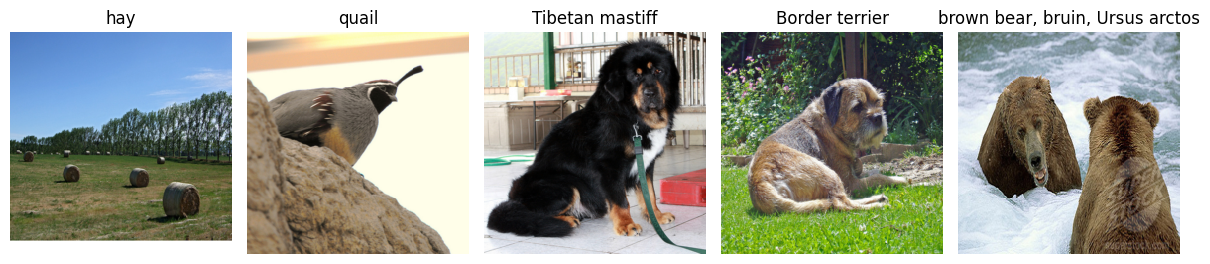

In [5]:
# show some images
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and 0.5MB model size
https://arxiv.org/abs/1602.07360

Recent research on deep neural networks has focused primarily on improving accuracy. For a given accuracy level, it is typically possible to identify multiple DNN architectures that achieve that accuracy level. With equivalent accuracy, smaller DNN architectures offer at least three advantages: (1) Smaller DNNs require less communication across servers during distributed training. (2) Smaller DNNs require less bandwidth to export a new model from the cloud to an autonomous car. (3) Smaller DNNs are more feasible to deploy on FPGAs and other hardware with limited memory. To provide all of these advantages, we propose a small DNN architecture called SqueezeNet. SqueezeNet achieves AlexNet-level accuracy on ImageNet with 50x fewer parameters. Additionally, with model compression techniques we are able to compress SqueezeNet to less than 0.5MB (510x smaller than AlexNet).

https://github.com/forresti/SqueezeNet

In [6]:
# Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016
model = torchvision.models.squeezenet1_1(pretrained=True)
#print(model)

for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 20.9MB/s]


In [7]:
X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
y_tensor = torch.LongTensor(y)
model.eval()
scores = model(X_tensor)
print(scores)
scores_y = scores.gather(1, y_tensor.view(-1, 1)).squeeze()
print(scores_y)

tensor([[ 9.0406,  1.1808,  3.4227,  ...,  4.6864,  8.0145,  5.2129],
        [ 5.9101,  4.6083,  6.9259,  ...,  9.7415,  9.6305,  9.3974],
        [ 1.6097,  4.0396,  4.4560,  ...,  3.4892, 11.6411, 12.5561],
        ...,
        [ 5.5077,  3.8930,  3.3218,  ...,  4.5410,  7.9065, 15.4184],
        [ 7.6427,  8.8772,  4.0593,  ...,  9.6345,  7.5668, 10.8771],
        [ 8.6750, 13.4218, 11.4606,  ...,  6.1399,  5.2605, 10.4970]])
tensor([24.1313, 25.1475, 38.8825, 25.4514, 30.2723, 25.4353, 15.6568, 34.9214,
        22.9094, 13.7762, 18.1419, 10.5448, 23.5066, 46.3714, 39.0091, 27.1299,
        25.8614, 19.7288, 18.6807, 20.9641, 25.2686, 18.7046, 21.7245, 12.6422,
        15.0523])


In [8]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    model.eval()
    X.requires_grad_()

    # 1. Forward pass
    scores = model(X)

    # 2. Get correct class scores
    scores = scores.gather(1, y.view(-1, 1)).squeeze()

    # 3. Backward pass
    scores_size = scores.shape
    ones_tensor = torch.ones(scores_size)
    scores.backward(ones_tensor)

    # 4. retrieve the gradient as saliency map
    saliency = X.grad
    return saliency

def compute_abs(saliency):
    saliency_abs = saliency.abs()
    return saliency_abs

def compute_max(saliency):
    saliency_max, _= torch.max(saliency, dim=1)
    return saliency_max

In [9]:
## calculating gradients for CORRECT labels
# Convert X and y from numpy arrays to Torch Tensors
X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
y_tensor = torch.LongTensor(y)

# Compute saliency maps for images in X
saliency = compute_saliency_maps(X_tensor, y_tensor, model)
saliency_max = compute_max(saliency)
saliency_maxabs = compute_max(compute_abs(saliency)) # what original authors did

# Convert the saliency map from Torch Tensor to numpy array and show images
# and saliency maps together.
#saliency = saliency.numpy()
print(saliency.shape)

torch.Size([25, 3, 224, 224])


In [10]:
hue_neg, hue_pos = 0, 359
cmap = sns.diverging_palette(hue_neg, hue_pos, s=100, center="dark", as_cmap=True)

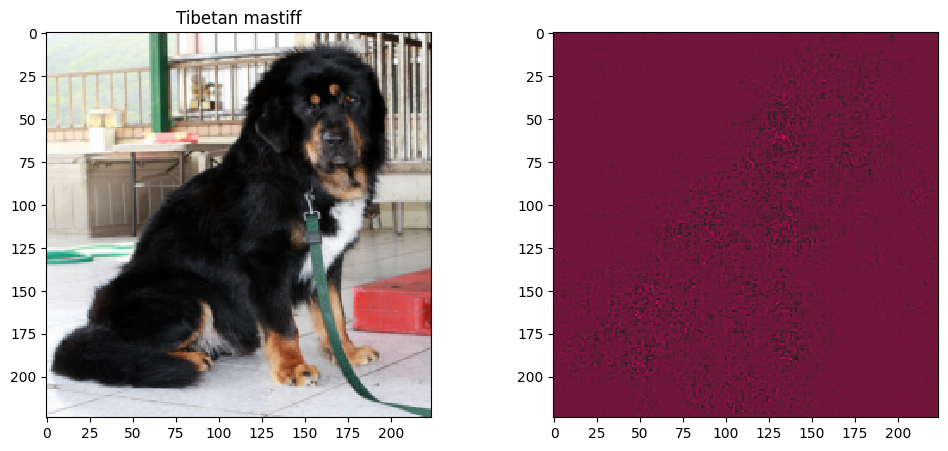

In [11]:
i = 2

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(X[i,:,:,:])
plt.title(class_names[y[i]])
plt.subplot(1, 2, 2)
plt.imshow(saliency_max[i,:,:].numpy(), cmap=cmap)
plt.gcf().set_size_inches(12, 5)


In [12]:
saliency_max[i,:,:].numpy()

array([[-5.6959433e-04,  1.3885004e-03,  2.3240333e-03, ...,
        -8.9034060e-05,  4.9511982e-05,  0.0000000e+00],
       [ 2.9082103e-03,  6.1952830e-03,  7.6641212e-03, ...,
         4.2653101e-04,  2.0675986e-06,  0.0000000e+00],
       [ 9.0336129e-03,  7.4838907e-03,  6.1066970e-03, ...,
         1.1076747e-04,  3.6587339e-04,  0.0000000e+00],
       ...,
       [-2.7070096e-04,  2.3340620e-03, -1.3610231e-03, ...,
         9.5762481e-04,  9.9336915e-04,  0.0000000e+00],
       [ 4.3300042e-04,  7.3457870e-04,  3.6031934e-03, ...,
         7.6837727e-04,  6.5263757e-04,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

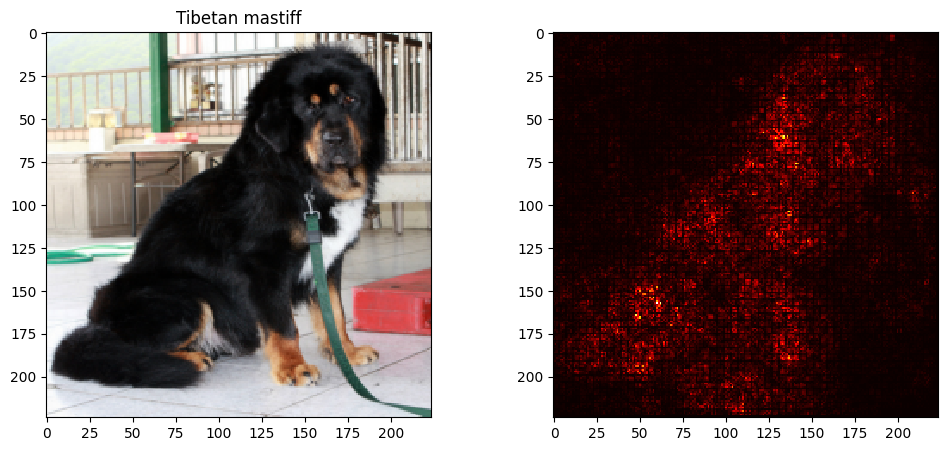

In [13]:
i = 2

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(X[i,:,:,:])
plt.title(class_names[y[i]])
plt.subplot(1, 2, 2)
plt.imshow(saliency_maxabs[i,:,:].numpy(), cmap=plt.cm.hot)
plt.gcf().set_size_inches(12, 5)


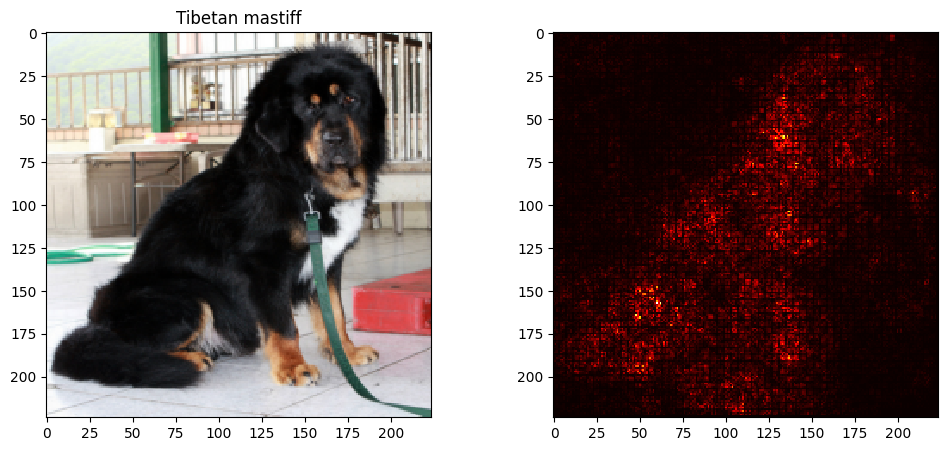

In [14]:
zi = 2

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(X[i,:,:,:])
plt.title(class_names[y[i]])
plt.subplot(1, 2, 2)
plt.imshow(saliency_maxabs[i,:,:].numpy(), cmap=plt.cm.hot)
plt.gcf().set_size_inches(12, 5)


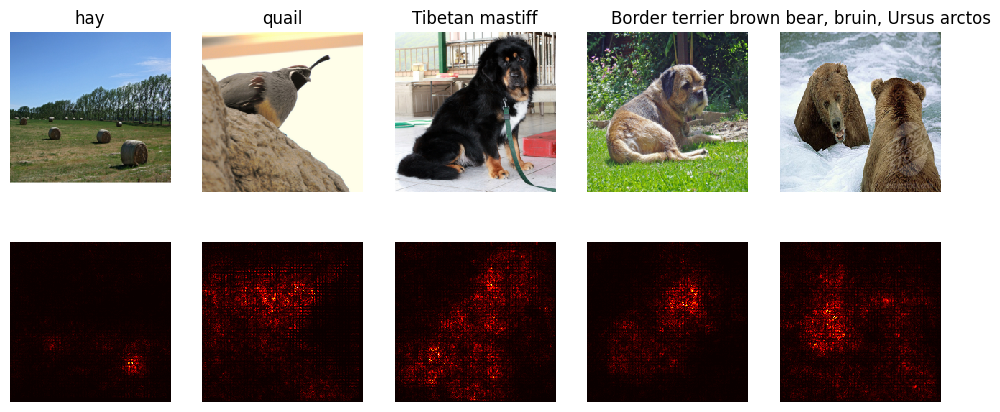

In [15]:
N = 5
for i in range(N):
    plt.subplot(2, N, i + 1)
    plt.imshow(X[i])
    plt.axis('off')
    plt.title(class_names[y[i]])
    plt.subplot(2, N, N + i + 1)
    plt.imshow(saliency_maxabs[i].numpy(), cmap=plt.cm.hot)
    plt.axis('off')
    plt.gcf().set_size_inches(12, 5)
plt.show()

(0.0, 0.25)

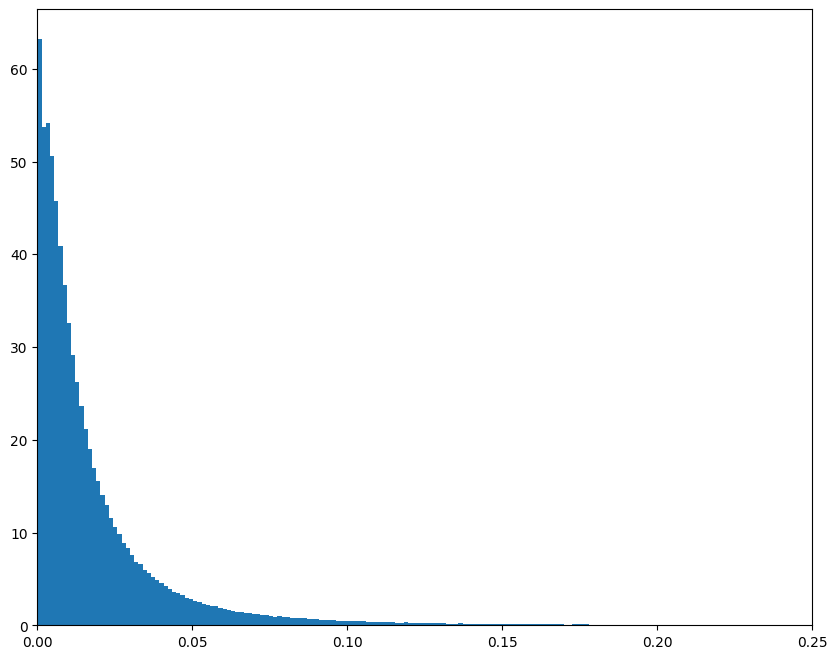

In [16]:
# look at the historgram of the saliency maps
plt.hist(saliency_maxabs.numpy().flatten(), density=True, bins=1000)
plt.xlim([0,0.25])

(-0.2, 0.2)

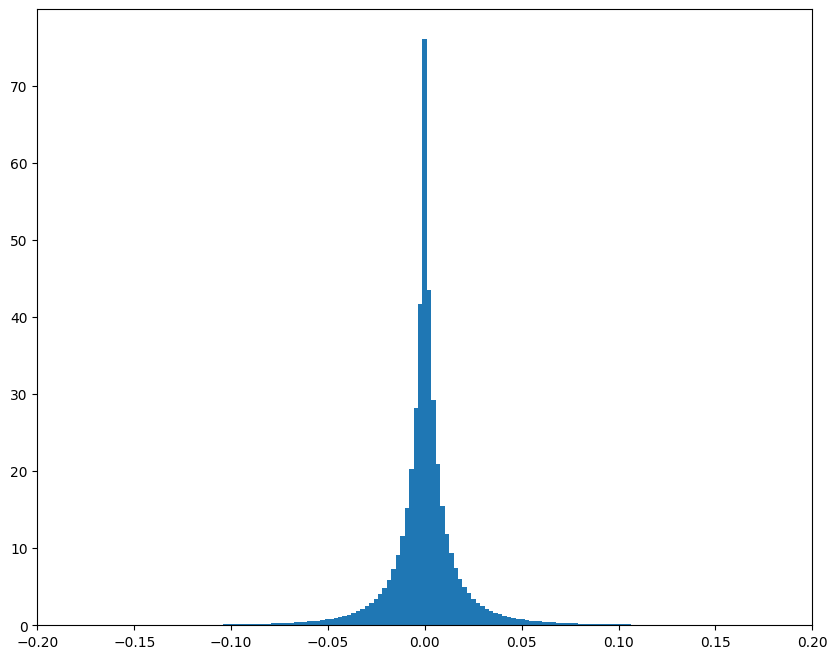

In [17]:
# look at the historgram of the saliency maps
plt.hist(saliency.numpy().flatten(), density=True, bins=1000)
plt.xlim([-.2,0.2])

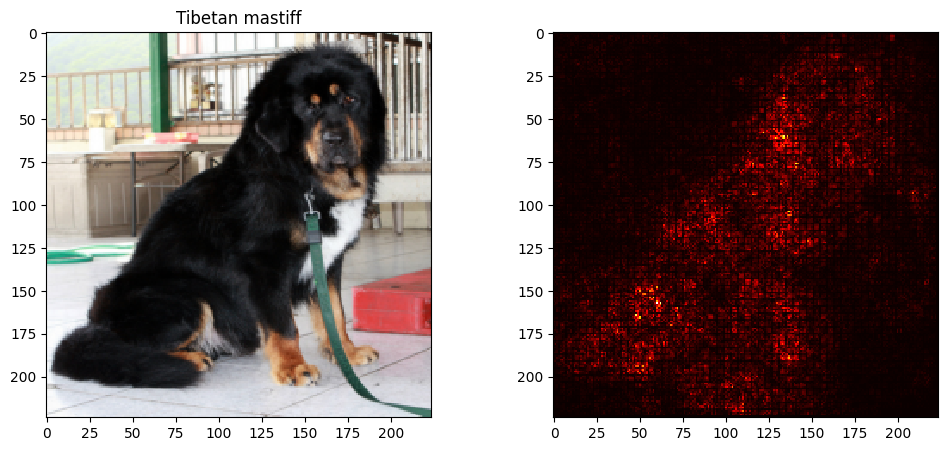

In [18]:
i = 2

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(X[i,:,:,:])
plt.title(class_names[y[i]])
plt.subplot(1, 2, 2)
plt.imshow(saliency_maxabs[i,:,:].numpy(), cmap=plt.cm.hot)
plt.gcf().set_size_inches(12, 5)


# Homework

Create a SmoothGrad. The basic steps are written below. See the paper: Smilkov et al. (2017) “SmoothGrad: removing noise by adding noise”

1. Add a slight (i.i.d. Gaussian) noise to the original image, creating multiple versions

2. Calculate importance scores (e.g., vanilla gradients) of those multiple ‘noisy’ images

3. Calculate average importance scores

You can make a function or write a for-loop. Visualize N=5 samples, with vanilla saliency maps and SmoothGrad maps

In [39]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import matplotlib.pyplot as plt

# Function to reverse image processing
def deprocess_image(x):
    x = x.reshape((x.shape[1], x.shape[2], 3))
    x = x - x.mean()
    x = x / (x.std() + 1e-5)
    x = x * 0.1
    x = x + 0.5
    x = np.clip(x, 0, 1)
    x = x * 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Function to compute saliency maps
def compute_saliency(model, img_input, class_idx):
    img_input = tf.convert_to_tensor(img_input)
    with tf.GradientTape() as tape:
        tape.watch(img_input)
        predictions = model(img_input)
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, img_input)
    return grads[0].numpy()

# SmoothGrad function with multiple noise additions
def smoothgrad(img_input, model, class_idx, noise_level=0.1, samples=10):
    stdev = noise_level * (np.max(img_input) - np.min(img_input))
    total_gradients = np.zeros_like(img_input)
    for i in range(samples):
        noise = np.random.normal(0, stdev, img_input.shape)
        noisy_img = img_input + noise
        grads = compute_saliency(model, noisy_img, class_idx)
        total_gradients += grads
    avg_gradients = total_gradients / samples
    return avg_gradients

# Function to scale gradients
def normalize_grads(grads):
    grads = np.abs(grads)
    grads = (grads - np.min(grads)) / (np.max(grads) - np.min(grads))
    return grads


model = VGG16(weights='imagenet')

f = np.load('imagenet_val_25.npz', allow_pickle=True)
X = f['X']
y = f['y']
class_names = f['label_map'].item()

noise_level = 0.1

# Generating images
for i in range(5):
    img = np.expand_dims(X[i], axis=0)
    img = preprocess_input(img)

    preds = model.predict(img)
    class_idx = np.argmax(preds[0])

    vanilla_grad = compute_saliency(model, img, class_idx)
    smooth_grad = smoothgrad(img, model, class_idx, noise_level=noise_level, samples=samples)

    vanilla_grad = normalize_grads(vanilla_grad)
    smooth_grad = normalize_grads(smooth_grad)

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].imshow(X[i].astype('uint8'))
    axs[0].set_title('Original')

    axs[1].imshow(vanilla_grad.squeeze(), cmap=plt.cm.hot)
    axs[1].set_title('Vanilla Saliency Map')

    axs[2].imshow(smooth_grad.squeeze(), cmap=plt.cm.hot)
    axs[2].set_title(f'SmoothGrad Map (noise={noise_level})')

    for ax in axs:
        ax.axis('on')

    plt.tight_layout(pad=2.0)
    plt.savefig(f'Zalewski_problem_{i+1}.pdf')
    plt.close()



1/1 [==============================] - 1s 518ms/step
